In [1271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge

In [1272]:
df = pd.read_csv('data_test.csv')

Data Cleaning

In [1273]:
df.head()

,date,order number,work number,material number,Unnamed: 4,processing time,start time,end time,output quantity,Loss quantity,OperatorEng,Continuous,moudle,number of teeth,thickness
0,7/19/2023,RPO2307020000,100,011-00062-01,#VALUE!,369.66882,08:52:36.803,15:02:16.933,15.0,0.0,Operator_3,False,1.75,69,20
1,7/14/2023,RPO2307020002,110,022-00009-02A3,#VALUE!,550.11067,08:03:41.243,17:13:47.883,30.0,0.0,Operator_6,False,2,16,98
2,9/11/2023,RPO2307020003,110,022-00009-02A3,#VALUE!,286.9775,14:00:18.767,18:47:17.417,10.0,0.0,Operator_6,False,2,16,98
3,9/12/2023,RPO2307020003,110,022-00009-02A3,#VALUE!,556.87688,20:07:29.303,05:24:21.917,20.0,0.0,Operator_6,True,2,16,98
4,7/6/2023,RPO2307020007,100,053-00009-02A1,#VALUE!,198.19417,17:05:57.337,20:24:08.987,18.0,0.0,Operator_1,False,1.75,84,19


In [1274]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821 entries, 0 to 820
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             821 non-null    object 
 1   order number     821 non-null    object 
 2   work number      821 non-null    int64  
 3   material number  821 non-null    object 
 4   Unnamed: 4       821 non-null    object 
 5   processing time  821 non-null    object 
 6   start time       821 non-null    object 
 7   end time         821 non-null    object 
 8   output quantity  821 non-null    float64
 9   Loss quantity    821 non-null    float64
 10  OperatorEng      820 non-null    object 
 11  Continuous       821 non-null    bool   
 12  moudle           817 non-null    object 
 13  number of teeth  817 non-null    object 
 14  thickness        817 non-null    object 
dtypes: bool(1), float64(2), int64(1), object(11)
memory usage: 90.7+ KB


In [1275]:
df['work number'] = df['work number'].astype(str)
df['processing time'] = df['processing time'].str.replace(r',', '', regex=True)
df['processing time'] = df['processing time'].astype(float)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['start time'] = pd.to_datetime(df['start time'], format='%H:%M:%S.%f').dt.time
df['end time'] = pd.to_datetime(df['end time'], format='%H:%M:%S.%f').dt.time
df['number of teeth'] = df['number of teeth'].str.replace(r' ', '', regex=True)
df['number of teeth'] = pd.to_numeric(df['number of teeth'], errors='coerce')
print("缺圖 value in thickness:",df[df['thickness'] == "缺圖"].shape[0])
df = df[df['thickness'] != "缺圖"]
df['thickness'] = df['thickness'].astype(float)

缺圖 value in thickness: 13


In [1276]:
df["moudle"].unique()

array(['1.75', '2', '1.5', '2.5', '3', '4', '5', '21', '4.5', '6', '6.35',
       '3.5', '2.25', '164', '25', '1.8', '38', '87.5', '135', '128', '7',
       '58', '0', '8', '10', '35', '187', '40', nan, '3.9789', '2.75',
       'DP32', '62', 'DP8'], dtype=object)

In [1277]:
df.replace("DP32", 25.4 / 32, inplace = True)
df.replace("DP8", 25.4 / 8, inplace = True)
df['moudle'] = df['moudle'].astype(float)
df.rename(columns={'moudle': 'module'}, inplace=True)
df[df['module'] == 0].shape[0]
df = df[(df['module'] > 0) & (df['number of teeth'] > 0) & (df['thickness'] > 0) & (df['output quantity'] > 0) & (df['processing time'] > 0)]

In [1278]:
duplicated = df[df['material number'] == df['Unnamed: 4']]
display(duplicated.head(4))
print(duplicated.shape[0])
print(df[df['Unnamed: 4'] == "#VALUE!"].shape[0])

,date,order number,work number,material number,Unnamed: 4,processing time,start time,end time,output quantity,Loss quantity,OperatorEng,Continuous,module,number of teeth,thickness
18,2023-08-18,RPO2307020023,100,101015,101015,223.17562,08:53:02.683000,12:36:13.220000,20.0,0.0,Operator_3,False,2.0,45.0,18.0
19,2023-07-10,RPO2307020024,80,102505,102505,154.27783,13:11:22.697000,15:45:39.367000,25.0,0.0,Operator_5,False,1.5,26.0,10.0
20,2023-07-25,RPO2307020025,80,102604,102604,69.30187,14:33:25.527000,15:42:43.640000,10.0,0.0,Operator_3,False,2.0,30.0,18.0
21,2023-07-18,RPO2307020027,100,104032,104032,275.20538,15:16:37.757000,19:51:50.080000,50.0,0.0,Operator_3,False,2.0,16.0,20.0


124
648


In [1279]:
df.drop(columns=['Unnamed: 4'], inplace=True)

In [1280]:
df.describe()

,date,processing time,output quantity,Loss quantity,module,number of teeth,thickness
count,774,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000
mean,2023-08-05 18:23:15.348836864,224.073714,15.788114,0.005168,4.151959,45.789264,31.945736
min,2023-07-03 00:00:00,10.000000,1.000000,0.000000,0.793750,2.000000,1.000000
25%,2023-07-21 00:00:00,105.688085,4.000000,0.000000,2.000000,26.000000,15.000000
50%,2023-08-07 00:00:00,176.837535,10.000000,0.000000,2.500000,39.000000,24.000000
75%,2023-08-22 00:00:00,296.921535,20.000000,0.000000,3.000000,56.000000,43.000000
max,2023-09-12 00:00:00,1126.426570,170.000000,3.000000,187.000000,315.000000,200.000000
std,NaN,166.553454,19.702025,0.113622,13.366342,31.292647,23.765191


In [1281]:
df = df.drop_duplicates(subset=['date', 'order number', 'work number', 'start time'])
df.shape[0]

773

In [1282]:
df.isnull().sum()

date               0
order number       0
work number        0
material number    0
processing time    0
start time         0
end time           0
output quantity    0
Loss quantity      0
OperatorEng        0
Continuous         0
module             0
number of teeth    0
thickness          0
dtype: int64

In [1283]:
df['OperatorEng'].value_counts()

OperatorEng
Operator_3     159
Operator_7     123
Operator_5     119
Operator_2     119
Operator_4      79
Operator_1      71
Operator_6      69
Operator_9      25
Operator_10      7
Operator_8       2
Name: count, dtype: int64

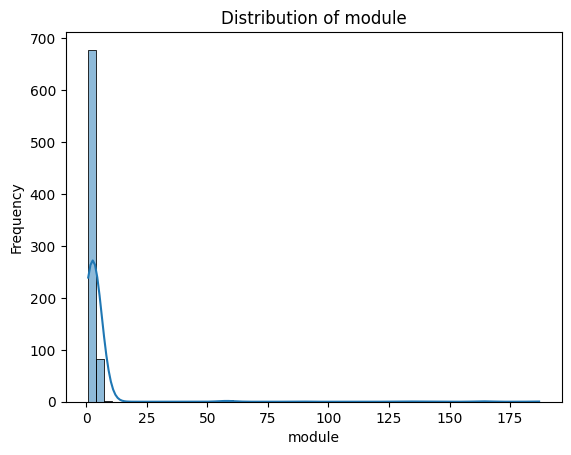

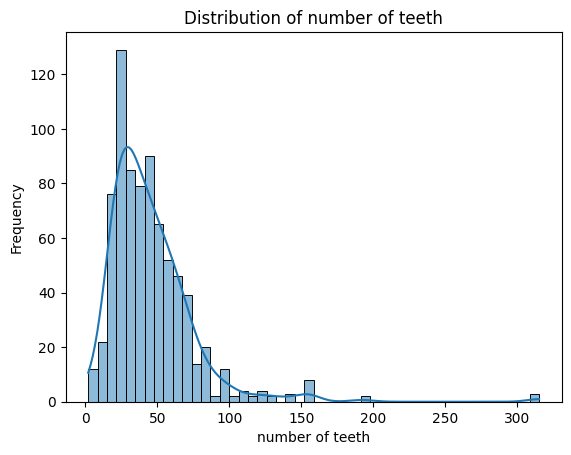

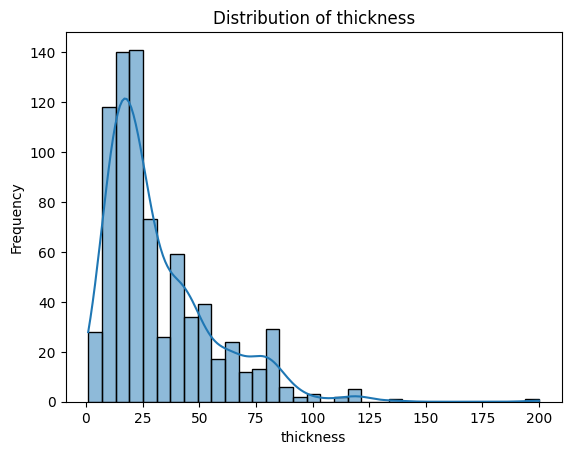

In [1284]:
numeric_nan_cols = ['module', 'number of teeth', 'thickness']

for col in numeric_nan_cols:
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

In [1285]:
df[df['material number'] == "102604"]

,date,order number,work number,material number,processing time,start time,end time,output quantity,Loss quantity,OperatorEng,Continuous,module,number of teeth,thickness
20,2023-07-25,RPO2307020025,80,102604,69.30187,14:33:25.527000,15:42:43.640000,10.0,0.0,Operator_3,False,2.0,30.0,18.0
709,2023-08-11,RPO2307180007,80,102604,95.42657,09:29:43.383000,11:05:08.977000,5.0,0.0,Operator_3,False,2.0,30.0,18.0


In [1286]:
df[df['module'].isna()]

,date,order number,work number,material number,processing time,start time,end time,output quantity,Loss quantity,OperatorEng,Continuous,module,number of teeth,thickness


In [1287]:
display(df[df['material number'] == "TML-10048"])
display(df[df['material number'] == "TML-10049"])
display(df[df['material number'] == "TML-10050"])
display(df[df['material number'].str.contains("TML-")].head(5))


,date,order number,work number,material number,processing time,start time,end time,output quantity,Loss quantity,OperatorEng,Continuous,module,number of teeth,thickness


,date,order number,work number,material number,processing time,start time,end time,output quantity,Loss quantity,OperatorEng,Continuous,module,number of teeth,thickness


,date,order number,work number,material number,processing time,start time,end time,output quantity,Loss quantity,OperatorEng,Continuous,module,number of teeth,thickness


,date,order number,work number,material number,processing time,start time,end time,output quantity,Loss quantity,OperatorEng,Continuous,module,number of teeth,thickness
473,2023-08-02,RPO2307020907,90,TML-10005,308.24663,10:11:40.837000,15:19:55.637000,30.0,0.0,Operator_2,False,2.5,39.0,30.0
474,2023-08-01,RPO2307020908,90,TML-10005,241.08375,10:45:12.490000,14:46:17.517000,20.0,0.0,Operator_2,False,2.5,39.0,30.0
475,2023-08-02,RPO2307020909,80,TML-10006,61.36397,15:20:40.100000,16:22:01.937000,2.0,0.0,Operator_2,False,2.5,27.0,12.0
476,2023-08-03,RPO2307020909,80,TML-10006,159.87155,07:35:44.287000,10:15:36.580000,28.0,0.0,Operator_2,True,2.5,27.0,12.0
477,2023-08-07,RPO2307020910,80,TML-10006,204.34058,15:23:14.573000,18:47:35.007000,20.0,0.0,Operator_6,False,2.5,27.0,12.0


In [1288]:
df['work number'].unique()

array(['100', '110', '80', '90', '70', '120', '30', '140', '130', '150',
       '10', '40'], dtype=object)

In [1289]:
df.dropna(inplace = True)

In [1290]:
df.isnull().sum()

date               0
order number       0
work number        0
material number    0
processing time    0
start time         0
end time           0
output quantity    0
Loss quantity      0
OperatorEng        0
Continuous         0
module             0
number of teeth    0
thickness          0
dtype: int64

In [1291]:
df.describe()

,date,processing time,output quantity,Loss quantity,module,number of teeth,thickness
count,773,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000
mean,2023-08-05 18:45:10.478654464,224.018631,15.769728,0.005175,4.154096,45.787697,31.948254
min,2023-07-03 00:00:00,10.000000,1.000000,0.000000,0.793750,2.000000,1.000000
25%,2023-07-21 00:00:00,105.513220,4.000000,0.000000,2.000000,26.000000,15.000000
50%,2023-08-07 00:00:00,176.659470,10.000000,0.000000,2.500000,39.000000,24.000000
75%,2023-08-22 00:00:00,297.365080,20.000000,0.000000,3.000000,56.000000,43.000000
max,2023-09-12 00:00:00,1126.426570,170.000000,3.000000,187.000000,315.000000,200.000000
std,NaN,166.654236,19.708136,0.113695,13.374864,31.312877,23.780475


In [1292]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 773 entries, 0 to 820
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             773 non-null    datetime64[ns]
 1   order number     773 non-null    object        
 2   work number      773 non-null    object        
 3   material number  773 non-null    object        
 4   processing time  773 non-null    float64       
 5   start time       773 non-null    object        
 6   end time         773 non-null    object        
 7   output quantity  773 non-null    float64       
 8   Loss quantity    773 non-null    float64       
 9   OperatorEng      773 non-null    object        
 10  Continuous       773 non-null    bool          
 11  module           773 non-null    float64       
 12  number of teeth  773 non-null    float64       
 13  thickness        773 non-null    float64       
dtypes: bool(1), datetime64[ns](1), float64(6), obje

In [1293]:
df.shape[0]

773

/var/folders/3q/m3mhwsps6nb6l4bnhg9cxrx40000gn/T/ipykernel_30877/1936439644.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=value, y="work number", data=df, palette='Set2')


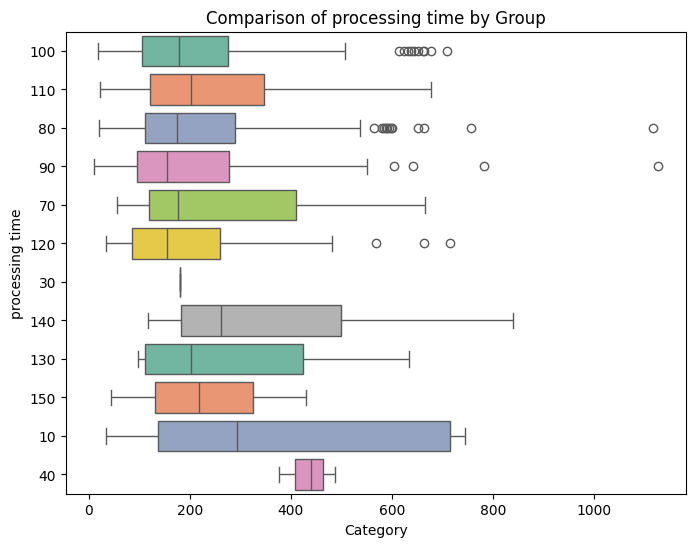

/var/folders/3q/m3mhwsps6nb6l4bnhg9cxrx40000gn/T/ipykernel_30877/1936439644.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=value, y="work number", data=df, palette='Set2')


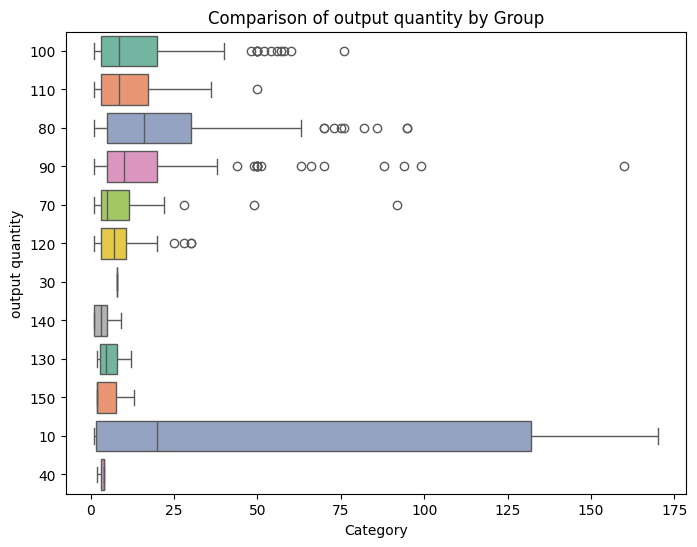

/var/folders/3q/m3mhwsps6nb6l4bnhg9cxrx40000gn/T/ipykernel_30877/1936439644.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=value, y="work number", data=df, palette='Set2')


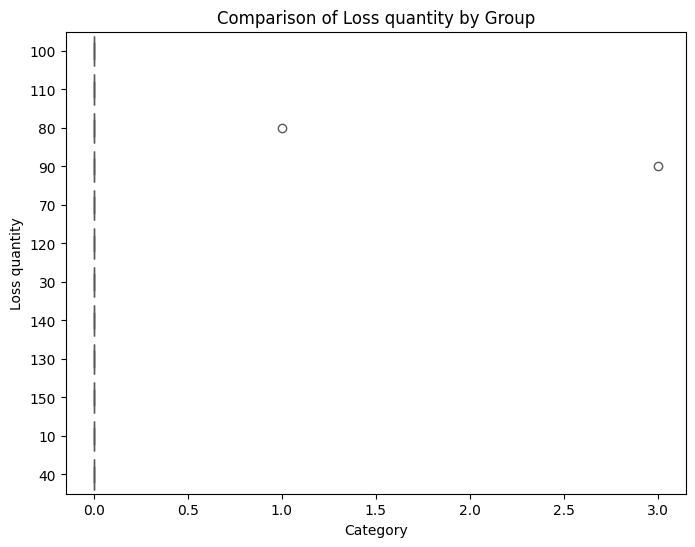

/var/folders/3q/m3mhwsps6nb6l4bnhg9cxrx40000gn/T/ipykernel_30877/1936439644.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=value, y="work number", data=df, palette='Set2')


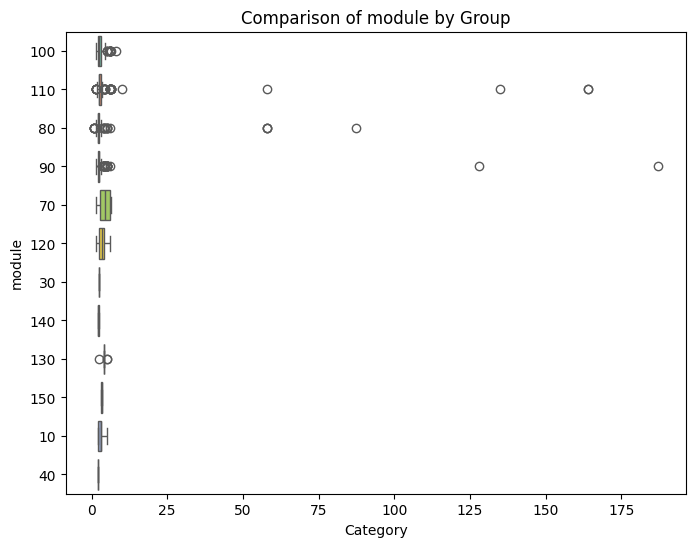

/var/folders/3q/m3mhwsps6nb6l4bnhg9cxrx40000gn/T/ipykernel_30877/1936439644.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=value, y="work number", data=df, palette='Set2')


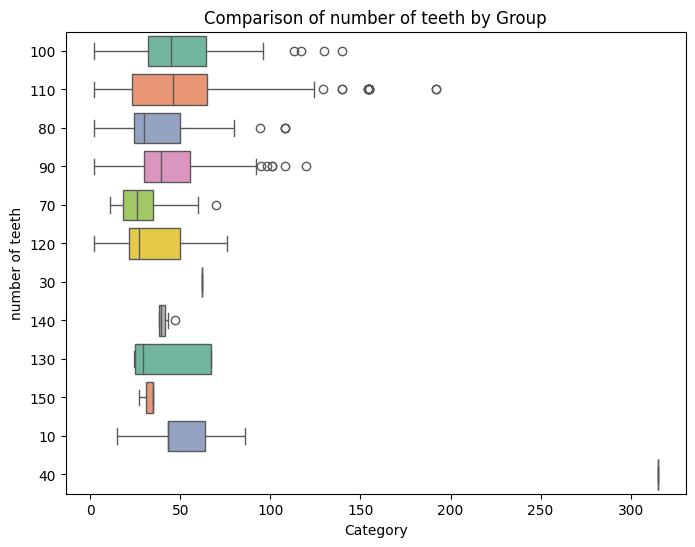

/var/folders/3q/m3mhwsps6nb6l4bnhg9cxrx40000gn/T/ipykernel_30877/1936439644.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=value, y="work number", data=df, palette='Set2')


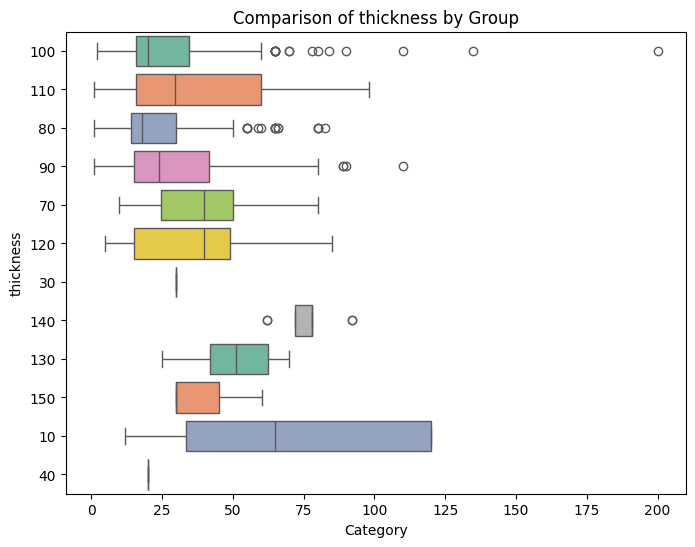

In [1294]:
numeric_cols = df.select_dtypes(include = [int, float]).columns

for value in numeric_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=value, y="work number", data=df, palette='Set2')
    plt.title(f'Comparison of {value} by Group')
    plt.xlabel('Category')
    plt.ylabel(value)
    plt.show()

In [1295]:
def remove_outliers_iqr(df, column) -> pd.DataFrame:
    """
    ลบแถวที่มีค่า Outlier ในคอลัมน์ที่กำหนดโดยใช้วิธี IQR

    Args:
        df (pd.DataFrame): DataFrame ต้นฉบับ
        column (str): ชื่อคอลัมน์ที่ต้องการตรวจสอบ Outlier

    Returns:
        pd.DataFrame: DataFrame ที่ถูกลบ Outlier ออกแล้ว
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1

    # กำหนดขอบเขตล่างและขอบเขตบนของข้อมูล
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # กรอง DataFrame เพื่อเก็บเฉพาะข้อมูลที่อยู่ในช่วงปกติ
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    print(f"ข้อมูลถูกลบไป {column}: {len(df) - len(df_filtered)} แถว จาก {len(df)} แถว")
    
    return df_filtered


# for col in numeric_cols:
#     df = remove_outliers_iqr(df, col)

In [1296]:
df['proc_time_per_unit'] = df['processing time'] / df['output quantity']
df['total_cutting_path'] = df['number of teeth'] * df['thickness'] * df['output quantity']
df['physical_volume_material_removed'] = (df['module'] ** 2) * df['number of teeth'] * df['thickness']
df.head()

,date,order number,work number,material number,processing time,start time,end time,output quantity,Loss quantity,OperatorEng,Continuous,module,number of teeth,thickness,proc_time_per_unit,total_cutting_path,physical_volume_material_removed
0,2023-07-19,RPO2307020000,100,011-00062-01,369.66882,08:52:36.803000,15:02:16.933000,15.0,0.0,Operator_3,False,1.75,69.0,20.0,24.644588,20700.0,4226.25
1,2023-07-14,RPO2307020002,110,022-00009-02A3,550.11067,08:03:41.243000,17:13:47.883000,30.0,0.0,Operator_6,False,2.00,16.0,98.0,18.337022,47040.0,6272.00
2,2023-09-11,RPO2307020003,110,022-00009-02A3,286.97750,14:00:18.767000,18:47:17.417000,10.0,0.0,Operator_6,False,2.00,16.0,98.0,28.697750,15680.0,6272.00
3,2023-09-12,RPO2307020003,110,022-00009-02A3,556.87688,20:07:29.303000,05:24:21.917000,20.0,0.0,Operator_6,True,2.00,16.0,98.0,27.843844,31360.0,6272.00
4,2023-07-06,RPO2307020007,100,053-00009-02A1,198.19417,17:05:57.337000,20:24:08.987000,18.0,0.0,Operator_1,False,1.75,84.0,19.0,11.010787,28728.0,4887.75


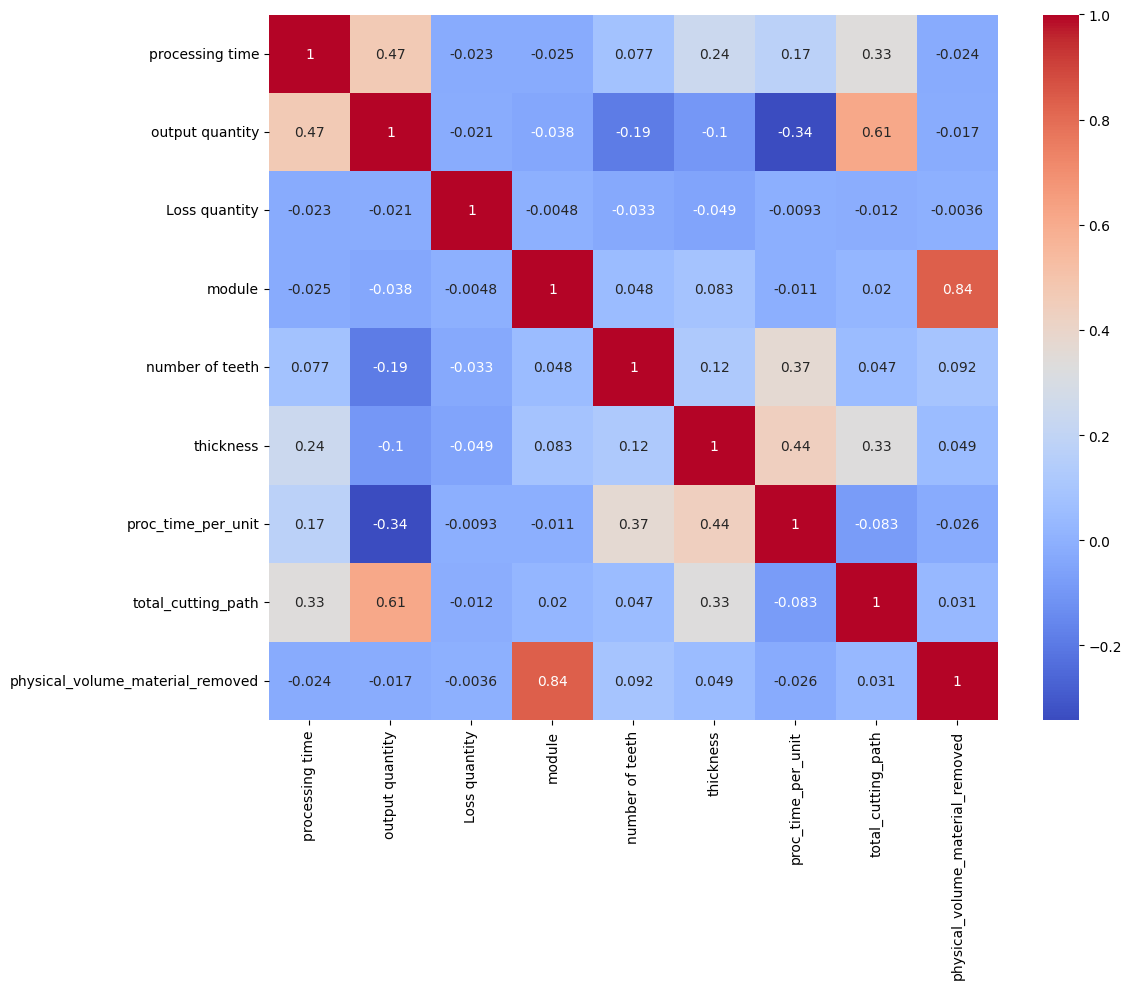

In [1297]:
num_cols = df.select_dtypes(include=[int, float]).columns

plt.figure(figsize=(12, 10))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.tight_layout()
plt.show()

In [1298]:
paradox = df.copy()
paradox.head(2)

,date,order number,work number,material number,processing time,start time,end time,output quantity,Loss quantity,OperatorEng,Continuous,module,number of teeth,thickness,proc_time_per_unit,total_cutting_path,physical_volume_material_removed
0,2023-07-19,RPO2307020000,100,011-00062-01,369.66882,08:52:36.803000,15:02:16.933000,15.0,0.0,Operator_3,False,1.75,69.0,20.0,24.644588,20700.0,4226.25
1,2023-07-14,RPO2307020002,110,022-00009-02A3,550.11067,08:03:41.243000,17:13:47.883000,30.0,0.0,Operator_6,False,2.00,16.0,98.0,18.337022,47040.0,6272.00


In [1299]:
paradox = pd.get_dummies(paradox, columns=['work number'], prefix='work_no', drop_first=True, dtype=int)
paradox.head(2)

,date,order number,material number,processing time,start time,end time,output quantity,Loss quantity,OperatorEng,Continuous,...,work_no_110,work_no_120,work_no_130,work_no_140,work_no_150,work_no_30,work_no_40,work_no_70,work_no_80,work_no_90
0,2023-07-19,RPO2307020000,011-00062-01,369.66882,08:52:36.803000,15:02:16.933000,15.0,0.0,Operator_3,False,...,0,0,0,0,0,0,0,0,0,0
1,2023-07-14,RPO2307020002,022-00009-02A3,550.11067,08:03:41.243000,17:13:47.883000,30.0,0.0,Operator_6,False,...,1,0,0,0,0,0,0,0,0,0


In [1300]:
paradox = pd.get_dummies(paradox, columns=['OperatorEng'], prefix='OperatorEng', drop_first=True, dtype=int)
paradox.head()

,date,order number,material number,processing time,start time,end time,output quantity,Loss quantity,Continuous,module,...,work_no_90,OperatorEng_Operator_10,OperatorEng_Operator_2,OperatorEng_Operator_3,OperatorEng_Operator_4,OperatorEng_Operator_5,OperatorEng_Operator_6,OperatorEng_Operator_7,OperatorEng_Operator_8,OperatorEng_Operator_9
0,2023-07-19,RPO2307020000,011-00062-01,369.66882,08:52:36.803000,15:02:16.933000,15.0,0.0,False,1.75,...,0,0,0,1,0,0,0,0,0,0
1,2023-07-14,RPO2307020002,022-00009-02A3,550.11067,08:03:41.243000,17:13:47.883000,30.0,0.0,False,2.00,...,0,0,0,0,0,0,1,0,0,0
2,2023-09-11,RPO2307020003,022-00009-02A3,286.97750,14:00:18.767000,18:47:17.417000,10.0,0.0,False,2.00,...,0,0,0,0,0,0,1,0,0,0
3,2023-09-12,RPO2307020003,022-00009-02A3,556.87688,20:07:29.303000,05:24:21.917000,20.0,0.0,True,2.00,...,0,0,0,0,0,0,1,0,0,0
4,2023-07-06,RPO2307020007,053-00009-02A1,198.19417,17:05:57.337000,20:24:08.987000,18.0,0.0,False,1.75,...,0,0,0,0,0,0,0,0,0,0


In [1301]:
paradox['Continuous'] = paradox['Continuous'].astype(int)

In [1302]:
work_no_cols = [col for col in paradox.columns if col.startswith('work_no_')]
operator_cols = [col for col in paradox.columns if col.startswith('OperatorEng_')]

# [work_no_cols + operator_cols + ['output quantity','module', 'number of teeth', 'thickness', 'Continuous']]
X = paradox[work_no_cols + operator_cols + ['output quantity','module', 'number of teeth', 'thickness', 'Continuous']]
y = paradox['processing time']

In [1303]:
# scaler = StandardScaler()
# num_cols_for_predict = ['output quantity','module', 'number of teeth', 'thickness', 'Continuous']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# x_train_scaled = scaler.fit_transform(x_train[num_cols_for_predict])
# x_test_scaled = scaler.transform(x_test[num_cols_for_predict])

param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.0001, 0.001],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.5, 0.01, 0.001]
}
xgb = XGBRegressor(objective='reg:squarederror', random_state=101)
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20, # ปรับเพิ่มได้ถ้ามีเวลา
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)
random_search.fit(x_train, y_train)
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R² Score: {r2}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Root Mean Squared Error: 122.75858141950879
R² Score: 0.38790665523956314


In [1304]:

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
train_set = lgb.Dataset(x_train, label=y_train_log)
test_set = lgb.Dataset(x_test, label=y_test_log, reference=train_set)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,          # ค่ามาตรฐาน แต่ปรับเพิ่มได้ถ้าข้อมูลเยอะ
    'feature_fraction': 0.8,   # สุ่มเลือก feature 80% ป้องกัน Overfitting
    'bagging_fraction': 0.8,   # สุ่มเลือกข้อมูล 80% 
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42
}

model = lgb.train(
    params,
    train_set,
    num_boost_round=1000,
    valid_sets=[train_set, test_set],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

# 9. Predict และแปลงค่ากลับ (Inverse Transform)
# ทำนายออกมาเป็นค่า Log ก่อน
y_pred_log = model.predict(x_test)

# แปลงค่า Log กลับมาเป็นหน่วย "นาที" ปกติ
y_pred_final = np.expm1(y_pred_log)

# 10. วัดผลด้วย RMSE ในหน่วยนาทีจริง
rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2 = r2_score(y_test, y_pred_final)

print(f"\n--- Results after Log Transformation ---")
print(f"Final RMSE: {rmse:.2f} minutes")
print(f"R-squared: {r2:.4f}")

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	training's rmse: 0.407691	valid_1's rmse: 0.574359

--- Results after Log Transformation ---
Final RMSE: 123.50 minutes
R-squared: 0.3805


In [1305]:
ridge = Ridge()
ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0]} # จูนค่าความเข้มงวด
grid_ridge = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
grid_ridge.fit(x_train, y_train)

best_ridge = grid_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(x_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

In [1306]:
rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 8, 10],      # ไม่ควรลึกเกินไปสำหรับข้อมูลน้อย
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(rf, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(x_train, y_train) # RF ไม่ต้องใช้ Scaled Data ก็ได้

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(x_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# 4. สรุปผลเปรียบเทียบ
print(f"Best Ridge Alpha: {grid_ridge.best_params_}")
print(f"Ridge RMSE: {rmse_ridge:.2f} minutes")
print("-" * 30)
print(f"Best RF Params: {grid_rf.best_params_}")
print(f"Random Forest RMSE: {rmse_rf:.2f} minutes")

Best Ridge Alpha: {'alpha': 10.0}
Ridge RMSE: 131.29 minutes
------------------------------
Best RF Params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest RMSE: 125.90 minutes


In [1307]:
import joblib
joblib.dump(best_model, 'xgb_model.pkl')

['xgb_model.pkl']

In [1308]:
df['work number'].unique()

array(['100', '110', '80', '90', '70', '120', '30', '140', '130', '150',
       '10', '40'], dtype=object)

In [1310]:
df['OperatorEng'].unique()

array(['Operator_3', 'Operator_6', 'Operator_1', 'Operator_5',
       'Operator_4', 'Operator_10', 'Operator_2', 'Operator_8',
       'Operator_7', 'Operator_9'], dtype=object)